In [1]:
import sys
import pickle
import gzip
import os,glob
import time
import numpy as np
import pandas as pd
import operator
import random
from  scipy import stats
#sys.path

import datetime
import math
import time
import itertools


from pymongo import MongoClient

import json

import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff


########## to be able to plot offline (without sending the plots to the plotly server every time)
import plotly.offline as offline
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
################

from IPython.core.display import display,HTML
display(HTML("<style>.container { width:100% !important; }</style>"))  # to make the notebook use the entire width of the browser


In [2]:
                                          # df_reference_cite_plos_merged     (original with ALL columns and all entries, without removing any references)

%time df_merged = pickle.load(open('../data/df_reference_cite_plos_merged_simplified_added_more_columns.pkl', 'rb'))
print ("done loading pickles", df_merged.shape)

df_merged = df_merged[df_merged['cite_count'] != -1]


df_merged.head()



,occurence,reference_UT,reference_rank,regex_sect_index,cite_count,ref_pub_year,paper_cite_count,plos_pub_year,sect_char_pos,sect_char_total,...,log2_num_cit_ref,log2_num_cit_paper,diff_year_plos_ref,rel_loc_in_sect,plos_field,isolated_citation,paper_UT,total_refs,categ_codes,self_citation
0,1,A1995QY75100004,1,0,60.0,1995.0,2,2013.0,139,4029,...,5.906891,1.0,18.0,0.034500,['D RO MULTIDISCIPLINARY SCIENCES'],0,000324515600133,37,0 5,0
1,2,A1995QY75100004,1,3,60.0,1995.0,2,2013.0,494,5398,...,5.906891,1.0,18.0,0.091515,['D RO MULTIDISCIPLINARY SCIENCES'],0,000324515600133,37,0 5,0
2,1,000222499800017,2,0,65.0,2004.0,2,2013.0,266,4029,...,6.022368,1.0,9.0,0.066021,['D RO MULTIDISCIPLINARY SCIENCES'],0,000324515600133,37,0 5,1
3,3,000222499800017,2,3,65.0,2004.0,2,2013.0,495,5398,...,6.022368,1.0,9.0,0.091701,['D RO MULTIDISCIPLINARY SCIENCES'],0,000324515600133,37,0 5,1
4,1,000263911400006,3,0,5.0,2009.0,2,2013.0,142,4029,...,2.321928,1.0,4.0,0.035244,['D RO MULTIDISCIPLINARY SCIENCES'],0,000324515600133,37,0 5,0


In [3]:
df_merged.shape
# #### i add a new column with shuffled paper_UTs  for the null model to compare usage of references by top/non-top plos papers
# df_merged.shape
# lista_values = list(df_merged.paper_UT)   #[i for i in range (len(df_merged))]
# random.shuffle(lista_values)
# df_merged['randomized_paper_UT'] = lista_values
# df_merged.head()

(6924262, 23)

In [6]:
df_merged[df_merged['paper_cite_count'] == -1]


,occurence,reference_UT,reference_rank,regex_sect_index,cite_count,ref_pub_year,paper_cite_count,plos_pub_year,sect_char_pos,sect_char_total,...,log2_num_cit_ref,log2_num_cit_paper,diff_year_plos_ref,rel_loc_in_sect,plos_field,isolated_citation,paper_UT,total_refs,categ_codes,self_citation


In [3]:

class MongoConnection(object):
    def __init__(self, cxnSettings, **kwargs):
        self.settings = cxnSettings
        self.mongoURI = self._constructURI()
        self.connect(**kwargs)
        self.ensure_index()

    def _constructURI(self):
        '''
        Construct the mongo URI
        '''
        mongoURI = 'mongodb://'
        #User/password handling
        if 'user'in self.settings and 'password' in self.settings:
            mongoURI += self.settings['user'] + ':' + self.settings['password']
            mongoURI += '@'
        elif 'user' in self.settings:
            print('Missing password for given user, proceeding without either')
        elif 'password' in self.settings:
            print('Missing user for given passord, proceeding without either')
        #Host and port
        try:
            mongoURI += self.settings['host'] + ':'
        except KeyError:
            print('Missing the hostname. Cannot connect without host')
            sys.exit()
        try:
            mongoURI += str(self.settings['port'])
        except KeyError:
            print('Missing the port. Substituting default port of 27017')
            mongoURI += str('27017')
        return mongoURI

    def connect(self, **kwargs):
        '''
        Establish the connection, database, and collection
        '''
        self.connection = MongoClient(self.mongoURI, **kwargs)
        #########
        try:
            self.db = self.connection[self.settings['db']]
        except KeyError:
            print("Must specify a database as a 'db' key in the settings file")
            sys.exit()
        #########
        try:
            self.collection = self.db[self.settings['collection']]
        except KeyError:
            print('Should have a collection.', end='')
            print('Starting a collection in database', end='')
            print(' for current connection as test.')
            self.collection = self.db['test']

    def tearDown(self):
        '''
        Closes the connection
        '''
        self.connection.close()

    def ensure_index(self):
        '''
        Ensures the connection has all given indexes.
        indexes: list of (`key`, `direction`) pairs.
            See docs.mongodb.org/manual/core/indexes/ for possible `direction`
            values.
        '''
        if 'indexes' in self.settings:
            for index in self.settings['indexes']:
                self.collection.ensure_index(index[0], **index[1])


# In[3]:


merged_papers_settings = {
    "host": "chicago.chem-eng.northwestern.edu",
    "port": "27017",
    "db": "web_of_science_aux",
    "collection": "merged_papers",
    "user": "mongoreader",
    "password": "emptycoffeecup"
}

papers_con = MongoConnection(merged_papers_settings)



In [4]:
df_ref=df_merged.drop_duplicates(subset=['reference_UT','cite_count','ref_pub_year'])
df_ref = df_ref[['reference_UT','cite_count','ref_pub_year','ref_field','ref_j1']]
print (df_ref.shape)


lista_all_ref = list(df_merged.reference_UT.unique())
print (len(lista_all_ref))



df_plos=df_merged.drop_duplicates(subset=['paper_UT','paper_cite_count','plos_pub_year'])
df_plos = df_plos[['paper_UT','paper_cite_count','plos_pub_year','plos_field','plos_j1','total_refs']]
print ("\n",df_plos.shape)



lista_all_plos = list(df_merged.paper_UT.unique())
print (len(lista_all_plos))


(2607453, 5)
2607453

 (158813, 6)
158813


In [ ]:
df_plos.shape

In [ ]:


# lista_all_plos_UTs = pickle.load(open('/home/staff/julia/at_Northwestern/In_Text_Citations/In-Text-Citations-New/data/lista_all_plos_UTs.pkl', 'rb'))
# new_lista_all_plos_UTs = ['000'+str(item) for item in lista_all_plos_UTs]   # i need to add the 000 so it matches the db UTs

# #print (len(new_lista_all_plos_UTs))


# # In[15]:




# #lista_UTs=['000322590800016','000254928800015','000305349100026','000321341000076']

# start=0
# stop=1000
# while stop <=159000:


#     lista=new_lista_all_plos_UTs[start:stop]
#     query = papers_con.collection.find({"UT":{"$in":lista}},{"UT":1,"AR":1}, no_cursor_timeout=True)  


#     #print (start, stop)

#     for item in query:  # query (cursor) is an iterator (once i iterate over it once, it is empty), and every item is a dict

#         UT=item["UT"]
#         doi=item['AR'][-1]
#         #string =str(UT)+" "+str(doi)
#         if ".pone." in doi:
#             print ( doi)

#     stop +=1000
#     start +=1000
        
     
#     query.close()  # because i am using the no_cursor_timeout=True, i need also this, or cursor keeps waiting so ur resources are used up
        


In [ ]:
df_merged.columns

In [ ]:
len(preselection_df3.paper_UT.unique())

In [4]:
########### i compare the usafe of top/nontop references by top/nontop plos papers with a null model that comes from randomizing the data

Niter=100

years=[2013]

string_references_age="young"   #young"#old"  # young # all   for the selection of what references i include
string_isolated_ref=""  #""   # 0  or 1 (or empty string, to include all ref)
string_self_ref=""#1   # 0  or 1 (or empty string, to include all ref)
string_journal=""
string_plos_field=""#['D CU BIOLOGY']"




##### preselection by plos year
print (years)
preselection_df = df_merged[df_merged['plos_pub_year'].isin(years)]  
print ("size of preselection1 (by plos years):",preselection_df.shape)



#### i remove self-citations
if (string_self_ref==0) or  ( string_self_ref == 1 ): 
    preselection_df = preselection_df[preselection_df['self_citation']== string_self_ref ]  
    print (" size of preselection1 (self-cit):",preselection_df.shape)




######### preselection by isolated or group references:
preselection_df0 = preselection_df   
if (string_isolated_ref==0) or  ( string_isolated_ref == 1 ): 
    preselection_df0 = preselection_df[preselection_df['isolated_citation']== string_isolated_ref ]        
    print ("  size of preselection1 (by isolated/group ref):",preselection_df0.shape, string_isolated_ref)




######### preselection by plos journal:
if string_journal=="": 
    preselection_df1 = preselection_df0
else:    
    preselection_df1 = preselection_df0[preselection_df0['plos_j1']== string_journal ]  
    print ("   size of preselection2 (by plos journal):",preselection_df1.shape, string_journal)







######### preselection by plos field:
if string_plos_field=="": 
    preselection_df2 = preselection_df1
else:    
    preselection_df2 = preselection_df1[preselection_df1['plos_field']== string_plos_field ]  
    print ("    size of preselection2 (by plos field):",preselection_df2.shape, string_plos_field)




 



##### preselection only young/old references:       
preselection_df3 = preselection_df2
if string_references_age == "young":
    time_window_age = 1   
    preselection_df3 = preselection_df2[preselection_df2['ref_pub_year'] >= (min(years)-time_window_age) ]   
    
    print ("    size of preselection3 (only young references):",preselection_df3.shape, string_references_age)

elif string_references_age == "old":
    time_window_age = 10    
    preselection_df3 = preselection_df2[preselection_df2['ref_pub_year'] <= (min(years)-time_window_age) ]   
    
    print ("    size of preselection3 (only old references):",preselection_df3.shape,string_references_age )





N_plos=len(preselection_df3.paper_UT.unique())        ## this values are overall, for the title   
N_all=len(preselection_df3)

    
    
         
print ("     N plos:", N_plos, " N records:", N_all)        
 
    
    
    
############## i define quantiles for plos papers (for that subselection, and based on their FINAL number of citations):
list_q_plos=[.2,.95,1]
df_for_quantiles_plos = preselection_df3.drop_duplicates(subset=['paper_UT'])   # ojo!!! dont use preselection_df3 directly because there are REPETITIONS!!!!

quantiles=sorted(list(df_for_quantiles_plos['paper_cite_count'].quantile(list_q_plos).to_dict().items())) #mean 10.68 
 
print ("\n\ncitation bins for the selected plos:", list_q_plos)#,quantiles, df_for_quantiles_plos.shape)   

lista_bins_plos=[]
old_value=0
for item in quantiles:
    pair=[old_value, int(item[1])]
    lista_bins_plos.append(pair)
    old_value = int(item[1])
                           
#print (lista_bins_plos, min(preselection_df3['paper_cite_count']), max(preselection_df3['paper_cite_count']))



cont = 0
dict_bin_list_plos_UT={}
for item in lista_bins_plos:
    
    minimo = item[0]
    maximo = item[1]   

    df_select = preselection_df3[(preselection_df3['paper_cite_count'] >= minimo)  &  (preselection_df3['paper_cite_count'] < maximo)]
    llave=str(minimo)+"-"+str(maximo)
    dict_bin_list_plos_UT[llave]= list(df_select.paper_UT.unique())
    print (llave, len(list(df_select.reference_UT.unique())))
    max_key_plos=llave

    
    if cont ==0:
        min_key_plos = llave
    cont  +=1
    
    
    
    
########## i define quantiles for references (based on their FINAL number of citations)
list_q_ref=[0.5,.95,1]
df_for_quantiles_ref = preselection_df3.drop_duplicates(subset=['reference_UT'])   # ojo!!! remember to remove REPETITIONS!!!!
quantiles=sorted(list(df_for_quantiles_ref['cite_count'].quantile(list_q_ref).to_dict().items())) #mean 10.68 
 
print ("\n\ncitation bins for the references in the selected plos:", list_q_ref,quantiles)    

lista_bins=[]
old_value=0
for item in quantiles:
    pair=[old_value, int(item[1])]
    lista_bins.append(pair)
    old_value = int(item[1])
                           



cont = 0
dict_bin_list_ref_UT={}
for item in lista_bins:
    
    minimo = item[0]
    maximo = item[1]    
     
    df_select = preselection_df3[(preselection_df3['cite_count'] >= minimo)  &  (preselection_df3['cite_count'] < maximo)]
    llave=str(minimo)+"-"+str(maximo)
    dict_bin_list_ref_UT[llave]=list(df_select.reference_UT.unique())
    print (llave, len(list(df_select.reference_UT.unique())))
    max_key_ref=llave

    if cont ==0:
        min_key_ref = llave
    cont  +=1


    

############### i create the list of top plos, top ref, bottom plos and bottom ref:
#########################

lista_top_plos = dict_bin_list_plos_UT[max_key_plos]
print ("\n\n# UTs top",(100-100*list_q_plos[-2]),"% plos:",len(lista_top_plos))

lista_top_ref=dict_bin_list_ref_UT[max_key_ref]
print ("# UTs top",(100-100*list_q_ref[-2]),"% ref:", len(lista_top_ref))


lista_bottom_plos = dict_bin_list_plos_UT[min_key_plos]
print ("# UTs bottom ",(100*list_q_plos[0]),"% plos:",len(lista_bottom_plos))

lista_bottom_ref=dict_bin_list_ref_UT[min_key_ref]
print ("# UTs bottom ",(100*list_q_ref[0]),"% ref:", len(lista_bottom_ref))

list_plos_in_year= list(preselection_df3.paper_UT.unique())
print ("Tot # records:",len(preselection_df3),", # plos:",len(list_plos_in_year))





######  i look at the usage of the top ref
################################################  

df_top_ref = preselection_df3[preselection_df3['reference_UT'].isin(lista_top_ref)]


df_top_ref_top_plos = df_top_ref[df_top_ref['paper_UT'].isin(lista_top_plos)]
df_top_ref_bottom_plos = df_top_ref[df_top_ref['paper_UT'].isin(lista_bottom_plos)]


usage_top_ref_top_plos = len(df_top_ref_top_plos)/float(len(df_top_ref))
usage_top_ref_bottom_plos = len(df_top_ref_bottom_plos)/float(len(df_top_ref))


print ("fraction of usage of top ref by ")
print ("  top",(100-100*list_q_plos[-2]),"% plos:",  usage_top_ref_top_plos)
print ("  bottom",(100*list_q_plos[0]),"% plos:",usage_top_ref_bottom_plos  )







######  i look at the usage of the non-top ref
################################################      

df_non_top_ref = preselection_df3[preselection_df3['reference_UT'].isin(lista_bottom_ref)]


df_non_top_ref_top_plos = df_non_top_ref[df_non_top_ref['paper_UT'].isin(lista_top_plos)]
df_non_top_ref_bottom_plos = df_non_top_ref[df_non_top_ref['paper_UT'].isin(lista_bottom_plos)]

usage_non_top_ref_top_plos = len(df_non_top_ref_top_plos)/float(len(df_non_top_ref))
usage_non_top_ref_bottom_plos = len(df_non_top_ref_bottom_plos)/float(len(df_non_top_ref))


print ("fraction of usage of non-top ref by ")
print ("  top",(100-100*list_q_plos[-2]),"% plos:", usage_non_top_ref_top_plos )
print ("  bottom",(100*list_q_plos[0]),"% plos:", usage_non_top_ref_bottom_plos )






####################
# I canculate the null model (usage of references by top and non top plos papers, from the randomized data)
#################################################  

lista_usage_top_ref_by_top_plos_rand = []
lista_usage_top_ref_by_bottom_plos_rand = []

lista_usage_nontop_ref_by_top_plos_rand = []
lista_usage_nontop_ref_by_bottom_plos_rand = []



for i in range(Niter):
    
    print (i)
    
    lista_values = list(preselection_df3.paper_UT)   #[i for i in range (len(df_merged))]
    random.shuffle(lista_values)
    preselection_df3['randomized_paper_UT'] = lista_values
   



    ####### (RANDOMIZED)  i look at the usage of the top ref
    df_top_ref_rand = preselection_df3[preselection_df3['reference_UT'].isin(lista_top_ref)]
    
    df_top_ref_top_plos_rand = df_top_ref_rand[df_top_ref_rand['randomized_paper_UT'].isin(lista_top_plos)]
    df_top_ref_bottom_plos_rand = df_top_ref_rand[df_top_ref_rand['randomized_paper_UT'].isin(lista_bottom_plos)]
    
    
    usage_top_ref_top_plos_rand = len(df_top_ref_top_plos_rand)/float(len(df_top_ref_rand))
    usage_top_ref_bottom_plos_rand = len(df_top_ref_bottom_plos_rand)/float(len(df_top_ref_rand))
    
    
    lista_usage_top_ref_by_top_plos_rand.append(usage_top_ref_top_plos_rand)
    lista_usage_top_ref_by_bottom_plos_rand.append(usage_top_ref_bottom_plos_rand)
    

    
    


    #######  (RANDOMIZED) i look at the usage of the non-top ref            
    df_non_top_ref_rand = preselection_df3[preselection_df3['reference_UT'].isin(lista_bottom_ref)]        
    
    df_non_top_ref_top_plos_rand = df_non_top_ref_rand[df_non_top_ref_rand['randomized_paper_UT'].isin(lista_top_plos)]
    df_non_top_ref_bottom_plos_rand = df_non_top_ref_rand[df_non_top_ref_rand['randomized_paper_UT'].isin(lista_bottom_plos)]
    
    
    usage_non_top_ref_top_plos_rand = len(df_non_top_ref_top_plos_rand)/float(len(df_non_top_ref_rand))
    usage_non_top_ref_bottom_plos_rand = len(df_non_top_ref_bottom_plos_rand)/float(len(df_non_top_ref_rand))
    
    
    lista_usage_nontop_ref_by_top_plos_rand.append(usage_non_top_ref_top_plos_rand)
    lista_usage_nontop_ref_by_bottom_plos_rand.append(usage_non_top_ref_bottom_plos_rand)

    







print ("\n\n\n\navg randomized!!")
print("fraction of usage of top ref by")
print ("  top",(100-100*list_q_plos[-2]),"% plos:",  np.mean(lista_usage_top_ref_by_top_plos_rand) )   
print ("  bottom",(100*list_q_plos[0]),"% plos:",np.mean(lista_usage_top_ref_by_bottom_plos_rand)  )




print ("\n\navg randomized")
print ("fraction of usage of non-top ref by ")
print ("  top",(100-100*list_q_plos[-2]),"% plos:", np.mean(lista_usage_nontop_ref_by_top_plos_rand) )   
print ("  bottom",(100*list_q_plos[0]),"% plos:", np.mean(lista_usage_nontop_ref_by_bottom_plos_rand) ,"\n\n\n")
















################ i plot it
##########################################
lista_bin_names=[" Usage of top "+str(int(100-100*list_q_ref[-2]))+"% ref", " Usage of bottom "+str(int(100*list_q_ref[0]))+" ref"]



lista_for_top_plos = [ usage_top_ref_top_plos, usage_non_top_ref_top_plos]
lista_for_bottom_plos = [usage_top_ref_bottom_plos, usage_non_top_ref_bottom_plos]






###### this is the null model 
lista_expectations_top = [np.mean(lista_usage_top_ref_by_top_plos_rand),np.mean(lista_usage_nontop_ref_by_top_plos_rand)]  
lista_expectations_bottom = [np.mean(lista_usage_top_ref_by_bottom_plos_rand), np.mean(lista_usage_nontop_ref_by_bottom_plos_rand)] 


list_errors_top = [2.*np.std(lista_usage_top_ref_by_top_plos_rand), 2.*np.std(lista_usage_nontop_ref_by_top_plos_rand)] 
list_errors_bottom = [ 2.*np.std(lista_usage_top_ref_by_bottom_plos_rand), 2.*np.std(lista_usage_nontop_ref_by_bottom_plos_rand)] 




z_score_top_ref_by_top_plos = (usage_top_ref_top_plos - np.mean(lista_usage_top_ref_by_top_plos_rand))/np.std(lista_usage_top_ref_by_top_plos_rand)
z_score_nontop_ref_by_top_plos = (usage_non_top_ref_top_plos - np.mean(lista_usage_nontop_ref_by_top_plos_rand))/np.std(lista_usage_nontop_ref_by_top_plos_rand)

z_score_top_ref_by_bottom_plos = (usage_top_ref_bottom_plos - np.mean(lista_usage_top_ref_by_bottom_plos_rand))/np.std(lista_usage_top_ref_by_bottom_plos_rand)
z_score_nontop_ref_by_bottom_plos = (usage_non_top_ref_bottom_plos - np.mean(lista_usage_nontop_ref_by_bottom_plos_rand))/np.std(lista_usage_nontop_ref_by_bottom_plos_rand)




print ('zscore top ref by top plos:', z_score_top_ref_by_top_plos)
print ('zscore nontop ref by top plos:', z_score_nontop_ref_by_top_plos)

print ('zscore top ref by bottom plos:', z_score_top_ref_by_bottom_plos)
print ('zscore nontop ref by bottom plos:', z_score_nontop_ref_by_bottom_plos)



title_string='zs top-ref by top plos: '+str(z_score_top_ref_by_top_plos)+';  zs top-ref by bottom plos: '+str(z_score_top_ref_by_bottom_plos)+\
'<br>zs nontop-ref by top plos: '+str(z_score_nontop_ref_by_top_plos)+';  zs nontop-ref by bottom plos: '+str(z_score_nontop_ref_by_bottom_plos)


trace1 = go.Bar(
    x=lista_bin_names,
    y=lista_for_top_plos,
    name='Top '+str(int(100-100*list_q_plos[-2]))+'% Plos',
    #text= lista_text_young,
    marker=dict(
        color='#00e673',#rgb(158,202,225)',
#         line=dict(
#             color='rgb(8,48,107)',
#             width=1.5,
#         )
    ),
    
    
    
)


trace2 = go.Bar(
    x=lista_bin_names,
    y=lista_expectations_top,
    name='expectations top '+str(int(100-100*list_q_plos[-2]))+'% Plos ('+str(Niter)+' iter)',
  #  text= lista_text_old,
    error_y=dict(
       # type='data',
        array=list_errors_top,#[0.5, 1, 2],
        visible=True
    ),
    marker=dict(
        color='#e6fff2',#'rgb(158,202,225)',
#         line=dict(
#             color='rgb(8,48,107)',
#             width=1.5,
#         )
    ),
)


trace3 = go.Bar(
    x=lista_bin_names,
    y=lista_for_bottom_plos,
    name='Bottom '+str(int(list_q_plos[0]*100))+'% Plos',
   # text= lista_text_old,    
    marker=dict(
        color='#ff6666',#'rgb(158,202,225)',
#         line=dict(
#             color='rgb(8,48,107)',
#             width=1.5,
#         )
    ),
)


trace4 = go.Bar(
    x=lista_bin_names,
    y=lista_expectations_bottom,
    name='expectations bottom '+str(int(list_q_plos[0]*100))+'% Plos ('+str(Niter)+' iter)',
  #  text= lista_text_old,
    error_y=dict(
       # type='data',
        array=list_errors_bottom,#[0.5, 1, 2],
        visible=True
    ),
    marker=dict(
        color='#ffe6e6',#'rgb(158,202,225)',
#         line=dict(
#             color='rgb(8,48,107)',
#             width=1.5,
#         )
    ),
)


data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    barmode='group',
    title=title_string,
 #   xaxis = dict(title= 'Plos Citation percentile'),
    yaxis = dict(title= 'Fraction of reference usage'),
    
)


# layout = {
#   'xaxis': {'title': 'Plos Citation percentile'},
#   'yaxis': {'title': 'Fraction of references in paper'},
 
# }





fig = go.Figure(data=data, layout=layout)
#py.iplot(fig, filename='grouped-bar')


fig_filename='fract_young_old_ref_vs_plos_cit_bin'
offline.plot(fig, auto_open=True, image = 'png', image_filename=fig_filename ,image_width=2000, image_height=2000,
              filename=fig_filename+'.html', validate=True)








#################### i plot the total number of references in papers by top/bottom plos category
################################

print("\n\nTotal number of references in different types of papers")
df_plos_select = preselection_df3.drop_duplicates(subset=['paper_UT','paper_cite_count','plos_pub_year'])

print ("\n",df_plos_select.shape)


x_all = df_plos_select['total_refs']
print ("All:",len(x_all), x_all.median())
trace1 = go.Histogram(x=x_all,
                     name='All plos '+str(int(np.nanmedian(x_all))),
                      histnorm='probability',
                     opacity = 0.75)


df_selected_top = df_plos_select[df_plos_select['paper_UT'].isin(lista_top_plos)]  # occurrences of not top references
x_top = df_selected_top['total_refs']
print ("Top plos:",len(x_top), x_top.median())
trace2 = go.Histogram(x=x_top,
                     name='top plos '+str(int(np.nanmedian(x_top))),
                      histnorm='probability',
                     opacity = 0.75)


df_selected_bottom = df_plos_select[df_plos_select['paper_UT'].isin(lista_bottom_plos)]  # occurrences of not top references
x_bottom = df_selected_bottom['total_refs']
print ("Bottom plos",len(x_bottom), x_bottom.median())
trace3 = go.Histogram(x=x_bottom,
                     name='bottom plos '+str(int(np.nanmedian(x_bottom))),
                      histnorm='probability',
                     opacity = 0.75)


random_lista = random.sample(list(x_all), len(x_top))
print ("Random:",len(random_lista), np.median(random_lista))
trace4 = go.Histogram(x=random_lista,
                     name='random sample '+str(int(np.nanmedian(random_lista))),
                      histnorm='probability',
                     opacity = 0.75)

data = [trace1, trace2, trace3]#, trace4]



fig = go.Figure(data=data)#, layout=layout)




#layout = go.Layout(barmode='overlay')





fig_filename='histogram_tot_num_references_per_paper'
offline.plot(fig, auto_open=True, image = 'png', image_filename=fig_filename ,image_width=2000, image_height=2000,
              filename=fig_filename+'.html', validate=True)






print ("comparison   ALL- top plos:", stats.ks_2samp(x_all, x_top),"\n"  )
print ("comparison   ALL- bottom plos:", stats.ks_2samp(x_all, x_bottom),"\n"  )
print ("comparison   top plos - bottom plos:", stats.ks_2samp(x_top, x_bottom),"\n"  )
print ("comparison   top plos - random:", stats.ks_2samp(x_top, random_lista),"\n"  )

     

    
    
##################################
    
    
    



print (preselection_df.shape, preselection_df3.shape)



df_ref = preselection_df.drop_duplicates(subset=['reference_UT'])
df_ref_young = preselection_df3.drop_duplicates(subset=['reference_UT'])

df_plos = preselection_df.drop_duplicates(subset=['paper_UT'])
df_plos_top = df_plos[df_plos['paper_UT'].isin(lista_top_plos)]


print (df_ref.shape, df_ref_young.shape, df_plos.shape,df_plos_top.shape )






#################### i plot the total number of citations received by the young (TOP) references and by the focus plos (TOP) papers
################################



lista_plos = list(df_plos['paper_cite_count'].dropna())
trace1 = go.Histogram(x=lista_plos,
                     name="all plos; median: "+str(df_plos['paper_cite_count'].median()),
                      histnorm='probability',
                     opacity = 0.75)


lista_plos_top = list(df_plos_top['paper_cite_count'].dropna())
trace2 = go.Histogram(x=lista_plos_top,
                     name="top plos; median: "+str(df_plos_top['paper_cite_count'].median()),
                      histnorm='probability',
                     opacity = 0.75)

lista_ref = list(df_ref['cite_count'].dropna())
trace3 = go.Histogram(x=lista_ref,
                     name="all ref; median: "+str(df_ref['cite_count'].median()),
                      histnorm='probability',
                     opacity = 0.75)


lista_ref_young = list(df_ref_young['cite_count'].dropna())
trace4 = go.Histogram(x=lista_ref_young,
                     name="all (young) ref; median: "+str(df_ref_young['cite_count'].median()),
                      histnorm='probability',
                     opacity = 0.75)

data =[trace1, trace2,trace3, trace4 ]

# layout = go.Layout(
#             title=str(years),
#             xaxis = dict(title= 'Final number of citations received'),
#                 # type='log'),#, autorange=True),
#             yaxis = dict(title= 'PDF'),
#     )
#                 # type='log'),#, autorange=True),        
                  
   




fig = go.Figure(data=data)#, layout=layout)


fig_filename='histogram_tot_num_citations_received_by_top_plos_and_by_top_young_ref'
offline.plot(fig, auto_open=True, image = 'png', image_filename=fig_filename ,image_width=2000, image_height=2000,
              filename=fig_filename+'.html', validate=True)



[2013]
size of preselection1 (by plos years): (1533850, 23)
    size of preselection3 (only young references): (145356, 23) young
     N plos: 29061  N records: 145356


citation bins for the selected plos: [0.2, 0.95, 1]
0-3 13632
3-28 72759
28-328 7337


citation bins for the references in the selected plos: [0.5, 0.95, 1] [(0.5, 18.0), (0.95, 104.0), (1.0, 6453.0)]
0-18 42804
18-104 40015
104-6453 4391


# UTs top 5.0 % plos: 1494
# UTs top 5.0 % ref: 4391
# UTs bottom  20.0 % plos: 4639
# UTs bottom  50.0 % ref: 42804
Tot # records: 145356 , # plos: 29061
fraction of usage of top ref by 
  top 5.0 % plos: 0.14983365764860962
  bottom 20.0 % plos: 0.09723181219006967
fraction of usage of non-top ref by 
  top 5.0 % plos: 0.03384774348376775
  bottom 20.0 % plos: 0.16220585294313714
0


/home/staff/julia/.pyenv/versions/3.6.4/envs/psy/lib/python3.6/site-packages/ipykernel_launcher.py:260: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99




avg randomized!!
fraction of usage of top ref by
  top 5.0 % plos: 0.0744278450819
  bottom 20.0 % plos: 0.124877283284


avg randomized
fraction of usage of non-top ref by 
  top 5.0 % plos: 0.0741880541297
  bottom 20.0 % plos: 0.124960835944 



zscore top ref by top plos: 36.3976155882
zscore nontop ref by top plos: -56.137270554
zscore top ref by bottom plos: -9.87264576258
zscore nontop ref by bottom plos: 32.6140201509


Total number of references in different types of papers

 (29061, 24)
All: 29061 47.0
Top plos: 1494 52.0
Bottom plos 4639 42.0
Random: 1494 46.0
comparison   ALL- top plos: Ks_2sampResult(statistic=0.11357953751622574, pvalue=1.8844313067244635e-16) 

comparison   ALL- botto

'file:///home/staff/julia/at_Northwestern/In_Text_Citations/In-Text-Citations-New/notebooks/histogram_tot_num_citations_received_by_top_plos_and_by_top_young_ref.html'

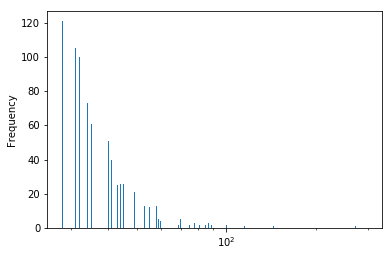

In [33]:
import matplotlib.pyplot as plt
df_plos_top['paper_cite_count'].plot.hist(bins=2000,logx=True)
plt.figure()

In [14]:
sorted(lista_plos)[-1]
#sorted(lista_plos_top)[-1]
#sorted(lista_ref)[-1]
#sorted(lista_ref_young)[-1]

328

In [16]:
###### check: if the "endorsement effect" is real (as opposed to just better plos papers being better at spotting quality in young references), 
####          succesful plos would get more citations than the young references they cite --->> i get the corresponding distributions:



years=[2013]

string_references_age="young"   #young"#old"  # young # all   for the selection of what references i include
string_isolated_ref=""  #""   # 0  or 1 (or empty string, to include all ref)
string_self_ref=""#1   # 0  or 1 (or empty string, to include all ref)
string_journal=""
string_plos_field=""#['D CU BIOLOGY']"





##### preselection by plos year
print (years)
preselection_df = df_merged[df_merged['plos_pub_year'].isin(years)]  
print ("size of preselection1 (by plos years):",preselection_df.shape)



#### i remove self-citations
if (string_self_ref==0) or  ( string_self_ref == 1 ): 
    preselection_df = preselection_df[preselection_df['self_citation']== string_self_ref ]  
    print (" size of preselection1 (self-cit):",preselection_df.shape)



######### preselection by isolated or group references:
preselection_df0 = preselection_df   
if (string_isolated_ref==0) or  ( string_isolated_ref == 1 ): 
    preselection_df0 = preselection_df[preselection_df['isolated_citation']== string_isolated_ref ]        
    print ("  size of preselection1 (by isolated/group ref):",preselection_df0.shape, string_isolated_ref)




######### preselection by plos journal:
if string_journal=="": 
    preselection_df1 = preselection_df0
else:    
    preselection_df1 = preselection_df0[preselection_df0['plos_j1']== string_journal ]  
    print ("   size of preselection2 (by plos journal):",preselection_df1.shape, string_journal)







######### preselection by plos field:
if string_plos_field=="": 
    preselection_df2 = preselection_df1
else:    
    preselection_df2 = preselection_df1[preselection_df1['plos_field']== string_plos_field ]  
    print ("    size of preselection2 (by plos field):",preselection_df2.shape, string_plos_field)




 



##### preselection only young/old references:       
preselection_df3 = preselection_df2
if string_references_age == "young":
    time_window_age = 1   
    preselection_df3 = preselection_df2[preselection_df2['ref_pub_year'] >= (min(years)-time_window_age) ]   
    
    print ("    size of preselection3 (only young references):",preselection_df3.shape, string_references_age)

elif string_references_age == "old":
    time_window_age = 10    
    preselection_df3 = preselection_df2[preselection_df2['ref_pub_year'] <= (min(years)-time_window_age) ]   
    
    print ("    size of preselection3 (only old references):",preselection_df3.shape,string_references_age )





N_plos=len(preselection_df3.paper_UT.unique())        ## this values are overall, for the title   
N_all=len(preselection_df3)

    
    
         
print ("     N plos:", N_plos, " N records:", N_all)        
 
    
    
    
############## i define quantiles for plos papers (for that subselection, and based on their FINAL number of citations):
list_q_plos=[.2,.95,1]
df_for_quantiles_plos = preselection_df3.drop_duplicates(subset=['paper_UT'])   # ojo!!! dont use preselection_df3 directly because there are REPETITIONS!!!!

quantiles=sorted(list(df_for_quantiles_plos['paper_cite_count'].quantile(list_q_plos).to_dict().items())) #mean 10.68 
 
print ("\n\ncitation bins for the selected plos:", list_q_plos)#,quantiles, df_for_quantiles_plos.shape)   

lista_bins_plos=[]
old_value=0
for item in quantiles:
    pair=[old_value, int(item[1])]
    lista_bins_plos.append(pair)
    old_value = int(item[1])
                           
#print (lista_bins_plos, min(preselection_df3['paper_cite_count']), max(preselection_df3['paper_cite_count']))



cont = 0
dict_bin_list_plos_UT={}
for item in lista_bins_plos:
    
    minimo = item[0]
    maximo = item[1]   

    df_select = preselection_df3[(preselection_df3['paper_cite_count'] >= minimo)  &  (preselection_df3['paper_cite_count'] < maximo)]
    llave=str(minimo)+"-"+str(maximo)
    dict_bin_list_plos_UT[llave]= list(df_select.paper_UT.unique())
    print (llave, len(list(df_select.reference_UT.unique())))
    max_key_plos=llave

    
    if cont ==0:
        min_key_plos = llave
    cont  +=1
    
    
lista_top_plos = dict_bin_list_plos_UT[max_key_plos]    # i create the list of top plos
print ("\n\n# UTs top",(100-100*list_q_plos[-2]),"% plos:",len(lista_top_plos))
    
   




    
########## i define quantiles for references (based on their FINAL number of citations)
list_q_ref=[0.5,.95,1]
df_for_quantiles_ref = preselection_df3.drop_duplicates(subset=['reference_UT'])   # ojo!!! remember to remove REPETITIONS!!!!
quantiles=sorted(list(df_for_quantiles_ref['cite_count'].quantile(list_q_ref).to_dict().items())) #mean 10.68 
 
print ("\n\ncitation bins for the references in the selected plos:", list_q_ref,quantiles)    

lista_bins=[]
old_value=0
for item in quantiles:
    pair=[old_value, int(item[1])]
    lista_bins.append(pair)
    old_value = int(item[1])
                           



cont = 0
dict_bin_list_ref_UT={}
for item in lista_bins:
    
    minimo = item[0]
    maximo = item[1]    
     
    df_select = preselection_df3[(preselection_df3['cite_count'] >= minimo)  &  (preselection_df3['cite_count'] < maximo)]
    llave=str(minimo)+"-"+str(maximo)
    dict_bin_list_ref_UT[llave]=list(df_select.reference_UT.unique())
    print (llave, len(list(df_select.reference_UT.unique())))
    max_key_ref=llave

    if cont ==0:
        min_key_ref = llave
    cont  +=1



lista_top_ref=dict_bin_list_ref_UT[max_key_ref]
print ("# UTs top",(100-100*list_q_ref[-2]),"% ref:", len(lista_top_ref))








print (preselection_df.shape, preselection_df3.shape)



df_ref = preselection_df.drop_duplicates(subset=['reference_UT'])
df_ref_young = preselection_df3.drop_duplicates(subset=['reference_UT'])

df_plos = preselection_df.drop_duplicates(subset=['paper_UT'])
df_plos_top = df_plos[df_plos['paper_UT'].isin(lista_top_plos)]


print (df_ref.shape, df_ref_young.shape, df_plos.shape,df_plos_top.shape )






#################### i plot the total number of citations received by the young (TOP) references and by the focus plos (TOP) papers
################################



lista= list(df_plos['paper_cite_count'].dropna())
trace1 = go.Histogram(x=lista,
                     name="all plos; median: "+str(df_plos['paper_cite_count'].median()),
                      histnorm='probability',
                     opacity = 0.75)


lista= list(df_plos_top['paper_cite_count'].dropna())
trace2 = go.Histogram(x=lista,
                     name="top plos; median: "+str(df_plos_top['paper_cite_count'].median()),
                      histnorm='probability',
                     opacity = 0.75)

lista= list(df_ref['cite_count'].dropna())
trace3 = go.Histogram(x=lista,
                     name="all ref; median: "+str(df_ref['cite_count'].median()),
                      histnorm='probability',
                     opacity = 0.75)


lista= list(df_ref_young['cite_count'].dropna())
trace4 = go.Histogram(x=lista,
                     name="all (young) ref; median: "+str(df_ref_young['cite_count'].median()),
                      histnorm='probability',
                     opacity = 0.75)

data =[trace1, trace2,trace3, trace4 ]

# layout = go.Layout(
#             title=str(years),
#             xaxis = dict(title= 'Final number of citations received'),
#                 # type='log'),#, autorange=True),
#             yaxis = dict(title= 'PDF'),
#     )
#                 # type='log'),#, autorange=True),        
                  
   




fig = go.Figure(data=data)#, layout=layout)


fig_filename='histogram_tot_num_citations_received_by_top_plos_and_by_top_young_ref'
offline.plot(fig, auto_open=True, image = 'png', image_filename=fig_filename ,image_width=2000, image_height=2000,
              filename=fig_filename+'.html', validate=True)



[2013]
size of preselection1 (by plos years): (1533850, 23)
    size of preselection3 (only young references): (145356, 23) young
     N plos: 29061  N records: 145356


citation bins for the selected plos: [0.2, 0.95, 1]
0-3 13632
3-28 72759
28-328 7337


# UTs top 5.0 % plos: 1494


citation bins for the references in the selected plos: [0.5, 0.95, 1] [(0.5, 18.0), (0.95, 104.0), (1.0, 6453.0)]
0-18 42804
18-104 40015
104-6453 4391
# UTs top 5.0 % ref: 4391
(1533850, 23) (145356, 23)
(870897, 23) (87211, 23) (34593, 23) (1494, 23)


'file:///home/staff/julia/at_Northwestern/In_Text_Citations/In-Text-Citations-New/notebooks/histogram_tot_num_citations_received_by_top_plos_and_by_top_young_ref.html'

In [34]:
###### more checks: if the "endorsement effect" is real (as opposed to just better plos papers being better at spotting quality in young references), 
#                   succesful plos would get more citations than the young references they cite --->> i get the (distributions of) ratios:
lista_paper_UT=[]
lista_ref_UT=[]
lista_num_ref=[]
lista_ratios_all=[]


for paper_UT, group in df_merged.groupby(['paper_UT']):  ### for df_merged: 158813 158813 5617059 2607457 43.600139787 0.0542472340106   # for preselection_df3: 6211 6211 30225 25508 6.34068587989 0.472185840259  # selected year: 7005 7005 260294 214744 46.4395431834 0.110949088539
        
        lista_paper_UT.append(paper_UT)
        lista_ref_UT += list(group.reference_UT.unique())
        lista_num_ref.append(len(group))
        num_cit_paper = float(group.paper_cite_count.unique()) # the group refers to one single plos
        lista_num_cit_ref = list(group.cite_count.values)
        list_ratios = [num_cit_paper/item   if item !=0  else 0 for item in lista_num_cit_ref]  #num_cit_paper / avg_num_cit_ref
        lista_ratios_all += list_ratios #.append(ratio)        
        
print (len(lista_paper_UT), len(set(lista_paper_UT)), len(lista_ref_UT), len(set(lista_ref_UT)), np.mean(lista_num_ref), np.mean(lista_ratios_all) )



lista_paper_UT=[]
lista_ref_UT=[]
lista_num_ref=[]

lista_ratios_selected_year=[]

for paper_UT, group in preselection_df.groupby(['paper_UT']):  ### for df_merged: 158813 158813 5617059 2607457 43.600139787 0.0542472340106   # for preselection_df3: 6211 6211 30225 25508 6.34068587989 0.472185840259  # selected year: 7005 7005 260294 214744 46.4395431834 0.110949088539
        
        lista_paper_UT.append(paper_UT)
        lista_ref_UT += list(group.reference_UT.unique())
        lista_num_ref.append(len(group))
        num_cit_paper = float(group.paper_cite_count.unique()) # the group refers to one single plos
        lista_num_cit_ref = list(group.cite_count.values)
        list_ratios = [num_cit_paper/item   if item !=0  else 0 for item in lista_num_cit_ref] #num_cit_paper / avg_num_cit_ref
        lista_ratios_selected_year += list_ratios #.append(ratio)   
        
        
print (len(lista_paper_UT), len(set(lista_paper_UT)), len(lista_ref_UT), len(set(lista_ref_UT)), np.mean(lista_num_ref), np.mean(lista_ratios_selected_year) )



lista_paper_UT=[]
lista_ref_UT=[]
lista_num_ref=[]

lista_ratios_selected_year_young_ref=[]


for paper_UT, group in preselection_df3.groupby(['paper_UT']):  ### for df_merged: 158813 158813 5617059 2607457 43.600139787 0.0542472340106   # for preselection_df3: 6211 6211 30225 25508 6.34068587989 0.472185840259  # selected year: 7005 7005 260294 214744 46.4395431834 0.110949088539
        
        lista_paper_UT.append(paper_UT)
        lista_ref_UT += list(group.reference_UT.unique())
        lista_num_ref.append(len(group))
        num_cit_paper = float(group.paper_cite_count.unique()) # the group refers to one single plos
        lista_num_cit_ref = list(group.cite_count.values)
        list_ratios = [num_cit_paper/item   if item !=0  else 0 for item in lista_num_cit_ref]  #num_cit_paper / avg_num_cit_ref
        lista_ratios_selected_year_young_ref += list_ratios #.append(ratio)   
        
        
print (len(lista_paper_UT), len(set(lista_paper_UT)), len(lista_ref_UT), len(set(lista_ref_UT)), np.mean(lista_num_ref), np.mean(lista_ratios_selected_year_young_ref) )







lista_paper_UT=[]
lista_ref_UT=[]
lista_num_ref=[]

lista_ratios_selected_year_young_ref_top_plos=[]
df_select = preselection_df3[preselection_df3['paper_UT'].isin(lista_top_plos)]

for paper_UT, group in df_select.groupby(['paper_UT']):  ### for df_merged: 158813 158813 5617059 2607457 43.600139787 0.0542472340106   # for preselection_df3: 6211 6211 30225 25508 6.34068587989 0.472185840259  # selected year: 7005 7005 260294 214744 46.4395431834 0.110949088539
        
        lista_paper_UT.append(paper_UT)
        lista_ref_UT += list(group.reference_UT.unique())
        lista_num_ref.append(len(group))
        num_cit_paper = float(group.paper_cite_count.unique()) # the group refers to one single plos
        
        lista_num_cit_ref = list(group.cite_count.values)
        list_ratios = [num_cit_paper/item   if item !=0  else 0 for item in lista_num_cit_ref]  #num_cit_paper / avg_num_cit_ref
        lista_ratios_selected_year_young_ref_top_plos += list_ratios #.append(ratio)   
        
        
print (len(lista_paper_UT), len(set(lista_paper_UT)), len(lista_ref_UT), len(set(lista_ref_UT)), np.mean(lista_num_ref), np.mean(lista_ratios_selected_year_young_ref_top_plos) )



lista_paper_UT=[]
lista_ref_UT=[]
lista_num_ref=[]

lista_ratios_selected_year_young_ref_top_plos_top_ref=[]

df_select = preselection_df3[preselection_df3['paper_UT'].isin(lista_top_plos)]
df_select = df_select[df_select['reference_UT'].isin(lista_top_ref)]


for paper_UT, group in df_select.groupby(['paper_UT']):  ### for df_merged: 158813 158813 5617059 2607457 43.600139787 0.0542472340106   # for preselection_df3: 6211 6211 30225 25508 6.34068587989 0.472185840259  # selected year: 7005 7005 260294 214744 46.4395431834 0.110949088539
        
        lista_paper_UT.append(paper_UT)
        lista_ref_UT += list(group.reference_UT.unique())
        lista_num_ref.append(len(group))
        num_cit_paper = float(group.paper_cite_count.unique()) # the group refers to one single plos
        lista_num_cit_ref = list(group.cite_count.values)
        list_ratios = [num_cit_paper/item   if item !=0  else 0 for item in lista_num_cit_ref]  #num_cit_paper / avg_num_cit_ref
        lista_ratios_selected_year_young_ref_top_plos_top_ref += list_ratios #.append(ratio)   
        
print (len(lista_paper_UT), len(set(lista_paper_UT)), len(lista_ref_UT), len(set(lista_ref_UT)), np.mean(lista_num_ref), np.mean(lista_ratios_selected_year_young_ref_top_plos_top_ref) )


# 158813 158813 5617059 2607457 43.600139787 0.0542472340106
# 7005 7005 260294 214744 46.4395431834 0.110949088539
# 6211 6211 30225 25508 6.34068587989 0.472185840259
# 312 312 2266 2092 9.46474358974 1.36087421586
# 169 169 379 293 3.01775147929 0.209680689138




 

trace1 = go.Histogram(x=lista_ratios_all,
                     name="all plos; mean: "+str(np.nanmean(lista_ratios_all)),
                      histnorm='probability',
                     opacity = 0.75)

trace2 = go.Histogram(x=lista_ratios_selected_year,
                     name="plos in selected year, all ref; mean: "+str(np.nanmean(lista_ratios_selected_year)),
                      histnorm='probability',
                     opacity = 0.75)

trace3 = go.Histogram(x=lista_ratios_selected_year_young_ref,
                     name="plos in selected year, young ref only; mean: "+str(np.nanmean(lista_ratios_selected_year_young_ref)),
                      histnorm='probability',
                     opacity = 0.75)

trace4 = go.Histogram(x=lista_ratios_selected_year_young_ref_top_plos,
                     name="TOP plos in selected year, young ref only; mean: "+str(np.nanmean(lista_ratios_selected_year_young_ref_top_plos)),
                      histnorm='probability',
                     opacity = 0.75)

trace5 = go.Histogram(x=lista_ratios_selected_year_young_ref_top_plos_top_ref,
                     name="TOP plos in selected year, TOP young ref only; mean: "+str(np.nanmean(lista_ratios_selected_year_young_ref_top_plos_top_ref)),
                      histnorm='probability',
                     opacity = 0.75)


data =[trace1,  trace2, trace3, trace4, trace5 ]

layout = go.Layout(
            title=str(years),
            xaxis = dict(title= 'Ratio final number of citations plos / final number citations ref'),
                # type='log'),#, autorange=True),
            yaxis = dict(title= 'PDF'),
    )
                # type='log'),#, autorange=True),        
                  
   




fig = go.Figure(data=data, layout=layout)


fig_filename='histogram_rations_num_cit_plos_num_cit_young_ref'
offline.plot(fig, auto_open=True, image = 'png', image_filename=fig_filename ,image_width=2000, image_height=2000,
              filename=fig_filename+'.html', validate=True)




158813 158813 5617055 2607453 43.60009571 0.294875095546
34593 34593 1244069 870897 44.3398953546 0.29303700373
29061 29061 112851 87211 5.00175492929 0.688195755498
1494 1494 8266 7337 7.21084337349 1.78019850253
811 811 1723 1162 2.94327990136 0.246966113346


'file:///home/staff/julia/at_Northwestern/In_Text_Citations/In-Text-Citations-New/notebooks/histogram_rations_num_cit_plos_num_cit_young_ref.html'

In [5]:
########  i study the number of citations that young references had at the time of the plos' publication


#############################3#############
#############################################     [[2006],[2007],[2008],[2009],[2010],[2011],[2012],[2013],[2014],[2015],[2016]]
for years in [[2008],[2009],[2010],[2011],[2012],[2013],[2014],[2015],[2016]]:



    print ("\n\n\nPLOS FROM YEAR:", years)

    string_references_age="young"   #young"#old"  # young # all   for the selection of what references i include
    string_isolated_ref=""  #""   # 0  or 1 (or empty string, to include all ref)
    string_self_ref=""#1   # 0  or 1 (or empty string, to include all ref)
    string_journal=""
    string_plos_field=""#['D CU BIOLOGY']"




    ##### preselection by plos year   
    preselection_df = df_merged[df_merged['plos_pub_year'].isin(years)]  
    print ("size of preselection1 (by plos years):",preselection_df.shape)


    #### i remove self-citations
    if (string_self_ref==0) or  ( string_self_ref == 1 ): 
        preselection_df = preselection_df[preselection_df['self_citation']== string_self_ref ]  
        print (" size of preselection1 (self-cit):",preselection_df.shape)


    ######### preselection by isolated or group references:
    preselection_df0 = preselection_df   
    if (string_isolated_ref==0) or  ( string_isolated_ref == 1 ): 
        preselection_df0 = preselection_df[preselection_df['isolated_citation']== string_isolated_ref ]        
        print ("  size of preselection1 (by isolated/group ref):",preselection_df0.shape, string_isolated_ref)


    ######### preselection by plos journal:
    if string_journal=="": 
        preselection_df1 = preselection_df0
    else:    
        preselection_df1 = preselection_df0[preselection_df0['plos_j1']== string_journal ]  
        print ("   size of preselection2 (by plos journal):",preselection_df1.shape, string_journal)


    ######### preselection by plos field:
    if string_plos_field=="": 
        preselection_df2 = preselection_df1
    else:    
        preselection_df2 = preselection_df1[preselection_df1['plos_field']== string_plos_field ]  
        print ("    size of preselection2 (by plos field):",preselection_df2.shape, string_plos_field)


    ##### preselection only young/old references:       
    preselection_df3 = preselection_df2
    if string_references_age == "young":
        time_window_age = 1   
        preselection_df3 = preselection_df2[preselection_df2['ref_pub_year'] >= (min(years)-time_window_age) ]   

        print ("    size of preselection3 (only young references):",preselection_df3.shape, string_references_age)

    elif string_references_age == "old":
        time_window_age = 10    
        preselection_df3 = preselection_df2[preselection_df2['ref_pub_year'] <= (min(years)-time_window_age) ]   

        print ("    size of preselection3 (only old references):",preselection_df3.shape,string_references_age )





    N_plos=len(preselection_df3.paper_UT.unique())        ## this values are overall, for the title   
    N_all=len(preselection_df3)


    print ("     N plos:", N_plos, " N records:", N_all)        




    ############## i define quantiles for plos papers (for that subselection, and based on their FINAL number of citations):
    list_q_plos=[.2,.95,1]
    df_for_quantiles_plos = preselection_df3.drop_duplicates(subset=['paper_UT'])   # ojo!!! dont use preselection_df3 directly because there are REPETITIONS!!!!

    quantiles=sorted(list(df_for_quantiles_plos['paper_cite_count'].quantile(list_q_plos).to_dict().items())) #mean 10.68 

    print ("citation bins for the selected plos:", list_q_plos)#,quantiles, df_for_quantiles_plos.shape)   

    lista_bins_plos=[]
    old_value=0
    for item in quantiles:
        pair=[old_value, int(item[1])]
        lista_bins_plos.append(pair)
        old_value = int(item[1])

    #print (lista_bins_plos, min(preselection_df3['paper_cite_count']), max(preselection_df3['paper_cite_count']))



    cont = 0
    dict_bin_list_plos_UT={}
    for item in lista_bins_plos:

        minimo = item[0]
        maximo = item[1]   

        df_select = preselection_df3[(preselection_df3['paper_cite_count'] >= minimo)  &  (preselection_df3['paper_cite_count'] < maximo)]
        llave=str(minimo)+"-"+str(maximo)
        dict_bin_list_plos_UT[llave]= list(df_select.paper_UT.unique())
        #print (llave, len(list(df_select.reference_UT.unique())))
        max_key_plos=llave


        if cont ==0:
            min_key_plos = llave
        cont  +=1




    ########## i define quantiles for references (based on their FINAL number of citations)
    list_q_ref=[0.5,.95,1]
    df_for_quantiles_ref = preselection_df3.drop_duplicates(subset=['reference_UT'])   # ojo!!! remember to remove REPETITIONS!!!!
    quantiles=sorted(list(df_for_quantiles_ref['cite_count'].quantile(list_q_ref).to_dict().items())) #mean 10.68 

    print ("\n\ncitation bins for the references in the selected plos:", list_q_ref,quantiles)    

    lista_bins=[]
    old_value=0
    for item in quantiles:
        pair=[old_value, int(item[1])]
        lista_bins.append(pair)
        old_value = int(item[1])




    cont = 0
    dict_bin_list_ref_UT={}
    for item in lista_bins:

        minimo = item[0]
        maximo = item[1]    

        df_select = preselection_df3[(preselection_df3['cite_count'] >= minimo)  &  (preselection_df3['cite_count'] < maximo)]
        llave=str(minimo)+"-"+str(maximo)
        dict_bin_list_ref_UT[llave]=list(df_select.reference_UT.unique())
        #print (llave, len(list(df_select.reference_UT.unique())))
        max_key_ref=llave

        if cont ==0:
            min_key_ref = llave
        cont  +=1




    ############### i create the list of top plos, top ref, bottom plos and bottom ref:
    #########################

    lista_top_plos = dict_bin_list_plos_UT[max_key_plos]
    #print ("\n\n# UTs top",(100-100*list_q_plos[-2]),"% plos:",len(lista_top_plos))

#     lista_top_ref=dict_bin_list_ref_UT[max_key_ref]
#     #print ("# UTs top",(100-100*list_q_ref[-2]),"% ref:", len(lista_top_ref))

    lista_bottom_plos = dict_bin_list_plos_UT[min_key_plos]
    #print ("# UTs bottom ",(100*list_q_plos[0]),"% plos:",len(lista_bottom_plos))

#     lista_bottom_ref=dict_bin_list_ref_UT[min_key_ref]
    #print ("# UTs bottom ",(100*list_q_ref[0]),"% ref:", len(lista_bottom_ref))

    list_plos_in_year= list(preselection_df3.paper_UT.unique())
    #print ("Tot # records:",len(preselection_df3),", # plos:",len(list_plos_in_year))

    #############################################
    ###############################################
    #############################################
    ###############################################








   
    lista_young_ref = list(preselection_df3.reference_UT.unique())
    
    lista_plos_cite_young_ref = list(preselection_df3.paper_UT.unique())

    lista_young_ref_cited_by_top_plos =  list(preselection_df3[preselection_df3['paper_UT'].isin(lista_top_plos)].reference_UT.unique())    

    lista_young_ref_cited_by_bottom_plos =  list(preselection_df3[preselection_df3['paper_UT'].isin(lista_bottom_plos)].reference_UT.unique())    

    print(len(lista_young_ref), len(lista_plos_cite_young_ref), len(lista_young_ref_cited_by_top_plos), len(lista_young_ref_cited_by_bottom_plos))

                                          
    
    print ("entering query for all citations of young references ..............")
    ############ i look for all citations of the young references used by plos of the focus year:
    cursor = papers_con.collection.find({"UT":{"$in":lista_young_ref}},{"UT":1,'citations':1}, no_cursor_timeout=True)  # it returns an iterator (it gets empty after iterating over it once) # second {} to select the fields it returns, if i dont want them all

    list_all_citing_papers_of_the_ref=[]
    dict_UT_ref_list_citing_papers={}
    for item in cursor:  # cursor is an iterator (once i iterate over it once, it is empty), and every item is a dict

        ref = item["UT"]

        list_citing_papers=item['citations']
        dict_UT_ref_list_citing_papers[ref]= list_citing_papers

        list_all_citing_papers_of_the_ref +=list_citing_papers


    cursor.close()  # because i am using the no_cursor_timeout=True, i need also this, or cursor keeps waiting so ur resources are used up
    print (len(list_all_citing_papers_of_the_ref))                                     
    list_all_citing_papers_of_the_ref = list(set(list_all_citing_papers_of_the_ref))                                     
    print (len(list_all_citing_papers_of_the_ref))
    print ("done collecting the list of citing papers of the young references.")  

    #################################


   



    lista_early_years_for_ref = sorted(years + [min(years)-1])   # i only care about the citations that the young references get early on (around the plos' publication year)

    
    
    
    
    try: 
        filename = '../data/dict_UT_year_for_citing_papers_of_young_ref_'+str(years).strip(']').strip('[')+'.pkl'
        dict_UT_year = pickle.load(open(filename, 'rb'))
        print ("done loading dict_UT_year")
    
    except:
    
        ############ i look for ONLY the early citations of the young references for the focus year:
        print ("entering long query for ONLY early citations of young references ..............")
        dict_UT_year={}
        start=0
        stop=10000
        while stop <=len(list_all_citing_papers_of_the_ref):

            #print ("  ",start, stop, "...")


            lista=list_all_citing_papers_of_the_ref[start:stop]       

            cursor = papers_con.collection.find({"UT":{"$in":lista}},{"UT":1, 'issue':1}, no_cursor_timeout=True)  # it returns an iterator (it gets empty after iterating over it once) # second {} to select the fields it returns, if i dont want them all

            #cursor = papers_con.collection.find({"UT":{"$in":lista},"issue.PY":{"$in":lista_early_years_for_ref}},{"UT":1, 'issue':1}, no_cursor_timeout=True)  # it returns an iterator (it gets empty after iterating over it once) # second {} to select the fields it returns, if i dont want them all
           ### is it faster to retrieve a cursor without the PY condition??!


            for item in cursor:  # cursor is an iterator (once i iterate over it once, it is empty), and every item is a dict

                cit = item["UT"]           
                year_ref=int(item['issue']['PY'])
                #if year_ref in lista_early_years_for_ref:

                dict_UT_year[cit]=year_ref

            stop  += 10000
            start += 10000
            cursor.close()  # because i am using the no_cursor_timeout=True, i need also this, or cursor keeps waiting so ur resources are used up



        with open('../data/dict_UT_year_for_citing_papers_of_young_ref_'+str(years).strip(']').strip('[')+'.pkl', 'wb') as handle:
            pickle.dump(dict_UT_year, handle, protocol = 2)   
        print ( len(dict_UT_year), '../data/dict_UT_year_for_citing_papers_of_young_ref_'+str(years).strip(']').strip('[')+'.pkl')

    
    
    
    
    dict_only_early_cit_UT_year={}
    for UT in dict_UT_year:
        year_cit = dict_UT_year[UT]
        if year_cit in lista_early_years_for_ref:
            
            dict_only_early_cit_UT_year[UT] = year_cit
    
    
    print ("full dict all citing papers:",len(dict_UT_year), "  only early citing papers:",len(dict_only_early_cit_UT_year))
    

    ###################  i get a dict with only the early citations of the young ref:

    new_dict_UT_early_cit={}
    for ref in dict_UT_ref_list_citing_papers:
        lista_citing=dict_UT_ref_list_citing_papers[ref]
        new_dict_UT_early_cit[ref] =0.
        for citing in lista_citing:
            try:
                dict_only_early_cit_UT_year[citing]
                new_dict_UT_early_cit[ref] +=1.
            except KeyError: pass

    print ('new dict created')       
    ################


    
#       lista_young_ref     
#     lista_plos_cite_young_ref 
#     lista_young_ref_cited_by_top_plos 
#     lista_young_ref_cited_by_bottom_plos   

    
    
    ####### i get the avg number of early citations for different subsets of young ref:
    list_values_all = []
    list_values_ref_by_top_plos = []
    list_values_ref_by_bottom_plos = []
    for ref in new_dict_UT_early_cit:
        if ref in lista_young_ref:
            list_values_all.append(new_dict_UT_early_cit[ref])
            
        if ref in lista_young_ref_cited_by_top_plos:
            list_values_ref_by_top_plos.append(new_dict_UT_early_cit[ref])
            
        if ref in lista_young_ref_cited_by_bottom_plos:
            list_values_ref_by_bottom_plos.append(new_dict_UT_early_cit[ref])


    print (years)
    print ("avg # early citations of young ref",np.mean(list_values_all), 2.*np.std(list_values_all),len(list_values_all))
    print ("  of young ref. cited by top plos",np.mean(list_values_ref_by_top_plos), 2.*np.std(list_values_ref_by_top_plos), len(list_values_ref_by_top_plos))
    print ("  of young ref. cited by bottom plos",np.mean(list_values_ref_by_bottom_plos), 2.*np.std(list_values_ref_by_bottom_plos), len(list_values_ref_by_bottom_plos))

    print ("\ncomparison   ALL- top plos:", stats.ks_2samp(list_values_all, list_values_ref_by_top_plos) )
    print ("comparison   ALL- bottom plos:", stats.ks_2samp(list_values_all, list_values_ref_by_bottom_plos)  )
    print ("comparison   top plos- bottom plos:", stats.ks_2samp(list_values_ref_by_top_plos, list_values_ref_by_bottom_plos)  )






PLOS FROM YEAR: [2008]
size of preselection1 (by plos years): (127714, 23)
    size of preselection3 (only young references): (17779, 23) young
     N plos: 2707  N records: 17779
citation bins for the selected plos: [0.2, 0.95, 1]


citation bins for the references in the selected plos: [0.5, 0.95, 1] [(0.5, 58.0), (0.95, 467.10000000000036), (1.0, 20654.0)]
11879 2707 1006 1901
entering query for all citations of young references ..............
1833140
1123339
done collecting the list of citing papers of the young references.
done loading dict_UT_year
full dict all citing papers: 1119422   only early citing papers: 86670
new dict created
[2008]
avg # early citations of young ref 13.6147823891 60.3934214023 11879
  of young ref. cited by top plos 24.7783300199 83.9423158842 1006
  of young ref. cited by bottom plos 15.3371909521 69.5331219346 1901

comparison   ALL- top plos: Ks_2sampResult(statistic=0.19824666781698902, pvalue=2.4146900525414032e-32)
comparison   ALL- bottom plos:

size of preselection1 (by plos years): (1190256, 23)
    size of preselection3 (only young references): (97191, 23) young
     N plos: 22937  N records: 97191
citation bins for the selected plos: [0.2, 0.95, 1]


citation bins for the references in the selected plos: [0.5, 0.95, 1] [(0.5, 7.0), (0.95, 45.0), (1.0, 4663.0)]
65776 22937 6060 0
entering query for all citations of young references ..............
1903021
1013627
done collecting the list of citing papers of the young references.
entering long query for ONLY early citations of young references ..............
1008515 ../data/dict_UT_year_for_citing_papers_of_young_ref_2015.pkl
full dict all citing papers: 1008515   only early citing papers: 303848
new dict created
[2015]
avg # early citations of young ref 8.56911755762 43.7013040637 65772
  of young ref. cited by top plos 17.2087458746 113.521992858 6060
  of young ref. cited by bottom plos nan nan 0

comparison   ALL- top plos: Ks_2sampResult(statistic=0.21439316619127702, pv

/home/staff/julia/.pyenv/versions/3.6.4/envs/psy/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning:

Mean of empty slice.

/home/staff/julia/.pyenv/versions/3.6.4/envs/psy/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning:

invalid value encountered in double_scalars

/home/staff/julia/.pyenv/versions/3.6.4/envs/psy/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/staff/julia/.pyenv/versions/3.6.4/envs/psy/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning:

invalid value encountered in true_divide

/home/staff/julia/.pyenv/versions/3.6.4/envs/psy/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning:

invalid value encountered in double_scalars

/home/staff/julia/.pyenv/versions/3.6.4/envs/psy/lib/python3.6/site-packages/scipy/stats/stats.py:4761: RuntimeWarning:

invalid value encountered in true_divide

/home/staff/julia/.pyenv/versions/3

size of preselection1 (by plos years): (311116, 23)
    size of preselection3 (only young references): (16481, 23) young
     N plos: 5129  N records: 16481
citation bins for the selected plos: [0.2, 0.95, 1]


citation bins for the references in the selected plos: [0.5, 0.95, 1] [(0.5, 4.0), (0.95, 28.0), (1.0, 2711.0)]
12409 5129 1652 0
entering query for all citations of young references ..............
337811
253814
done collecting the list of citing papers of the young references.
entering long query for ONLY early citations of young references ..............
249623 ../data/dict_UT_year_for_citing_papers_of_young_ref_2016.pkl
full dict all citing papers: 249623   only early citing papers: 118557
new dict created
[2016]
avg # early citations of young ref 12.9108639587 106.543930357 12408
  of young ref. cited by top plos 19.4491525424 192.385110703 1652
  of young ref. cited by bottom plos nan nan 0

comparison   ALL- top plos: Ks_2sampResult(statistic=0.12772728833853969, pvalue=3.

In [96]:
list(set(lista_young_ref)&set(lista_young_ref_cited_by_top_plos))
#list(set(lista_young_ref_cited_by_top_plos))

['000367805100045',
 '000367888100170',
 '000373039400002',
 '000372565700072',
 '000373038200006',
 '000373038600002',
 '000369552800029',
 '000369554000046',
 '000369368200049',
 '000371223400050',
 '000368529100016',
 '000371276100203',
 '000369527800125',
 '000373038200004',
 '000373272500001']